# Chapter 7. 토픽 모델링으로 주제 찾기

## 7.1 토픽 모델링과 LDA의 이해

## 7.2 사이킷런을 이용한 토픽 모델링

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space',
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size: ', len(newsgroups_train.data))
print('#Selected categories: ', newsgroups_train.target_names)

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

#Train set size:  3219
#Selected categories:  ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)  #소수점 반올림

lda = LatentDirichletAllocation(n_components=10,  #추출할 topic의 수
                                max_iter=5,
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online',
                                n_jobs=-1,  #사용 프로세서 수(-1이면 가능한 모든 프로세서 사용)
                                random_state=0)

review_topics = lda.fit_transform(review_cv)  #문서별 토픽분포(θ)
print('#Shape of review_topics: ', review_topics.shape)
print('#Sample of review_topics: ', review_topics[0])
gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents: ', gross_topic_weights)
print('#Shape of topic word distribution: ', lda.components_.shape)

#Shape of review_topics:  (3219, 10)
#Sample of review_topics:  [0.897 0.007 0.03  0.008 0.007 0.008 0.008 0.007 0.007 0.021]
#Sum of topic weights of documents:  [0.087 0.082 0.086 0.112 0.116 0.132 0.091 0.072 0.071 0.152]
#Shape of topic word distribution:  (10, 2000)


In [3]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d: ' % topic_idx, end='')
        #역순으로 했을 때 처음부터 n_top_words까지
        print(', '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: com, morality, article, sgi, sandvik, objective, keith, think, moral, don't
Topic #1: image, file, graphics, files, ftp, available, software, use, mail, pub
Topic #2: space, access, nasa, launch, orbit, earth, digex, shuttle, lunar, satellite
Topic #3: article, just, com, don't, like, nntp, host, posting, university, i'm
Topic #4: clipper, chip, key, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, bit, ibm, know, thanks, posting, university, nntp, host
Topic #6: gov, nasa, host, university, nntp, posting, distribution, ___, center, washington
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem
Topic #8: key, public, message, faq, pgp, mail, des, group, uni, sci
Topic #9: god, people, don't, jesus, just, believe, say, think, does, know



n_components: 6, perplexity: 1066.256
n_components: 7, perplexity: 1046.719
n_components: 8, perplexity: 1018.639
n_components: 9, perplexity: 1018.832
n_components: 10, perplexity: 1030.630
n_components: 11, perplexity: 1032.380
n_components: 12, perplexity: 1029.338
n_components: 13, perplexity: 1036.695
n_components: 14, perplexity: 1036.269
n_components: 15, perplexity: 1048.876


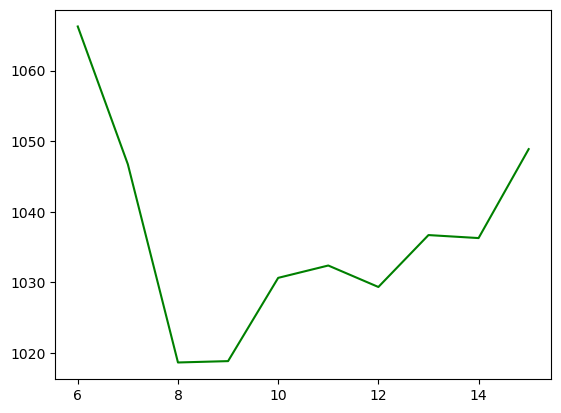

n_components with minimum perplexity: 8


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components=i,
                                        max_iter=max_iter, 
                                        topic_word_prior=topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs=-1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:", show_perplexity(review_cv, start=6, end=15))

In [5]:
lda = LatentDirichletAllocation(n_components=8,  #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs=-1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: graphics, image, mail, file, available, ftp, information, files, software, data
Topic #1: space, nasa, gov, center, ___, orbit, earth, research, washington, 1993
Topic #2: com, keith, nntp, posting, host, morality, article, caltech, sgi, objective
Topic #3: com, article, jesus, know, posting, host, nntp, just, don't, university
Topic #4: people, god, don't, does, think, say, believe, just, like, way
Topic #5: drive, scsi, card, com, thanks, disk, ide, controller, university, bus
Topic #6: space, article, access, just, com, like, year, digex, launch, henry
Topic #7: key, encryption, clipper, chip, government, com, keys, use, security, public



## 7.3 Gensim을 이용한 토픽 모델링

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{3,}")
english_stops = set(stopwords.words('english'))

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(texts)
print('#Number of initial unique words in documents: ', len(dictionary))

dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words: ', len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents:  46466
#Number of unique words after removing rare and common words:  2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [7]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
model = LdaModel(corpus=corpus, id2word=dictionary, 
                 passes=passes, num_topics=num_topics, 
                 random_state=7)

model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [8]:
print('#Topic distribution of the first document: ', model.get_document_topics(corpus)[0])

#Topic distribution of the first document:  [(0, 0.7257712), (8, 0.26994875)]


In [9]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

#LDA 모형을 pyLDAvis 객체에 전달
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655435
5      0.065989  0.123619       2        1  14.522820
9      0.072133  0.092872       3        1  12.987432
7      0.138320  0.043609       4        1  11.020434
4     -0.021828  0.007493       5        1   9.298346
6      0.072783 -0.094709       6        1   9.118885
3      0.027375 -0.054949       7        1   8.494168
0     -0.040787 -0.129975       8        1   4.524055
2      0.005361 -0.091972       9        1   4.051840
1     -0.182145  0.063762      10        1   3.326584, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.444019  1672.570798  Topic10  -5.1558   0.1469
789          sci    53.263350   309.473968  Topic10  -5.3463   1.6436
602   university    56.862522  1487.219070  Topic10  -5.2809   0.1392
294         time    55.766880  1187.715289  Topic10  -5.3004   0.3446
315       better    54.192160   564.543700  Topic10  -5.3290   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


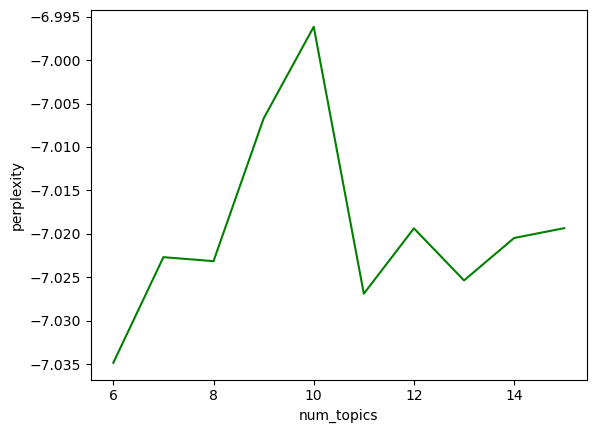

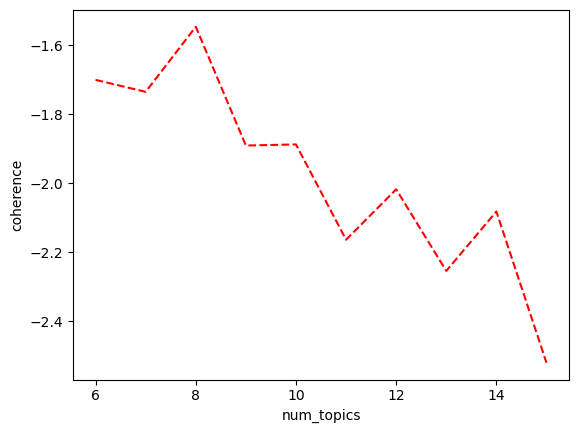

In [11]:
#혼란도와 토픽 응집도를 이용한 최적값 선택
from gensim.models import CoherenceModel

def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []
    
    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary, chunksize=1000, num_topics=i, random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:.3f}, coherence: {cv:.3f}')
        
    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel('num_topics')
    plt.ylabel('perplexity')
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel('num_topics')
    plt.ylabel('coherence')
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

## 7.4 토픽 트렌드로 시간에 따른 주제의 변화 알아내기

In [12]:
import pandas as pd

df = pd.read_csv('./data/petition_sampled.csv')
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, max_df=0.5, min_df=5, max_features=1000)
pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [17]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=15, n_jobs=-1, random_state=0)
pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d: ' % topic_idx, end='')
        print(', '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_top_words(lda, vec.get_feature_names_out(), 15)

Topic #0: 사람, 생각, 병원, 피해자, 사건, 정말, 환자, 처벌, 대통령, 나라, 가족, 국민, 자신, 지금, 인간
Topic #1: 북한, 우리, 한국, 대통령, 정부, 대한민국, 국민, 미국, 일본, 문재인, 국가, 나라, 문제, 생각, 우리나라
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 저희, 출산, 결혼
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 사찰, 생각, 게임, 이용, 외국인, 사회, 노인, 나이, 축구
Topic #4: 정부, 주택, 정책, 부동산, 서민, 아파트, 국민, 대통령, 나라, 세금, 지금, 사람, 서울, 투기, 집값
Topic #5: 일자리, 생각, 기업, 정부, 근무, 지원, 근로자, 시간, 임금, 최저임금, 정책, 사람, 대기업, 문제, 직원
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 대통령, 세금, 청와대, 정치, 생각, 반대, 대한민국, 나라, 국가, 투표
Topic #7: 내용, 대한, 조사, 관리, 판결, 관련, 업무, 공사, 사실, 판사, 확인, 기관, 해당, 결과, 발생
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 선생님, 교사, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 소득, 방송, 국민, 의료, 건강, 가입, 보험료, 제도, 기초, 공단
Topic #10: 여성, 공무원, 사회, 생각, 남성, 남자, 의무, 대한민국, 사람, 여자, 행정, 군대, 나라, 국가, 문제
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 조직, 대한민국, 불법, 만행, 경찰서, 수사, 범죄자, 부정부패, 검찰, 살인마
Topic #12: 처벌, 사건, 피해자, 범죄, 피해, 기사, 대한, 경우, 행위, 차량, 가해자, 이명박, 청원, 택시, 폭행
Topic #13: 민원, 화폐, 가상, 정부, 투자, 시장, 거래, 계획, 규제, 주식, 흡

In [19]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.466050,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.029717,2017-08
4,0.000447,0.049779,0.000447,0.000447,2017-08


In [20]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.029371,0.015640,0.026044,0.029202,0.103677
2017-09,0.041568,0.022710,0.106852,0.019687,0.038689
2017-10,0.086303,0.053113,0.062658,0.032142,0.092432
2017-11,0.044325,0.040040,0.235659,0.040443,0.048006
2017-12,0.052780,0.030459,0.064833,0.054095,0.078071


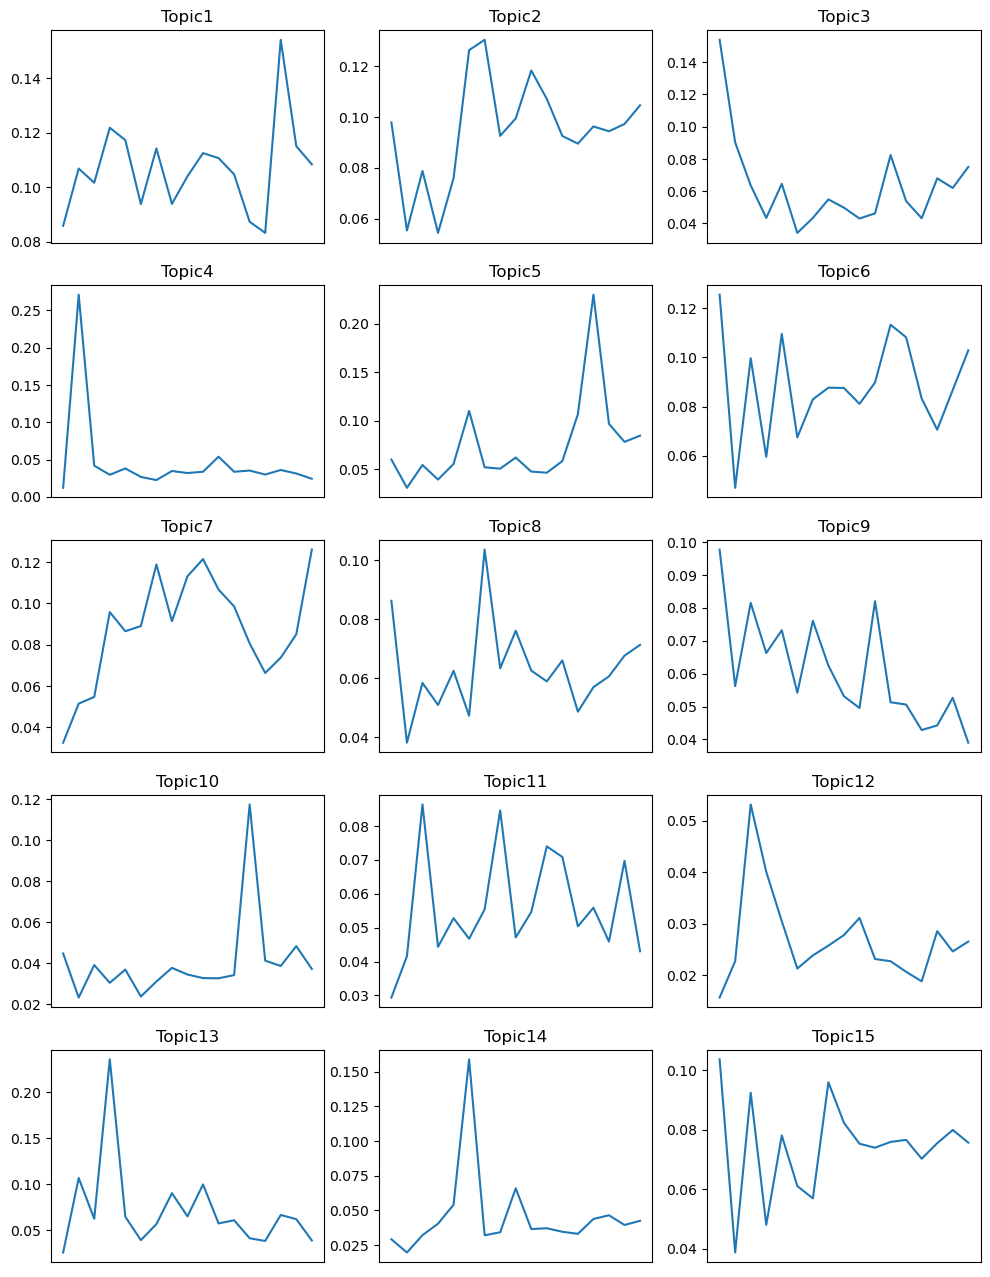

In [21]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])

plt.show()

## 7.5 동적 토픽 모델링